In [13]:
# Configure CUDA settings for PyTorch
import torch
import numpy as np
import pandas as pd
import os
from ultralytics import YOLO
import squarify
import matplotlib.pyplot as plt
import cv2
import random
import matplotlib.image as mpimg
import seaborn as sns
from sklearn.cluster import KMeans
from torchvision import models, transforms
from PIL import Image

# Set up CUDA device
torch.cuda.empty_cache()  # Clear GPU memory
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    # Print GPU info
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"Available GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    
    # Set PyTorch to use the GPU
    torch.backends.cudnn.benchmark = True  # Enable cuDNN auto-tuner
    torch.backends.cuda.matmul.allow_tf32 = True  # Allow TF32 on Ampere GPUs

# Set up visualization
sns.set_style('darkgrid')
%matplotlib inline

Using device: cuda
GPU Name: NVIDIA GeForce GTX 1660 Ti
Available GPU memory: 6.03 GB


/home/mozer/projects/yolo_ship/archive/ships-aerial-images/test/labels/ship_000539_png.rf.c2459e9e984d6ee241439b519ebc15b2.txt
1573
1573


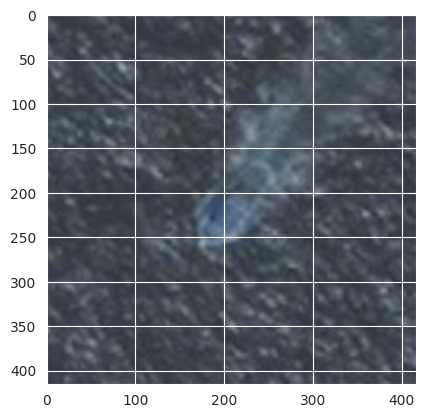

In [14]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from pathlib import Path 
path = Path("/home/mozer/projects/yolo_ship/archive/ships-aerial-images/test") 
test_images = [] 
test_labels = [] 
i = 0 
for subfolder in path.iterdir(): 
    if subfolder.is_dir():
        for file in subfolder.iterdir():
            if file.suffix.lower() in ['.jpg', '.jpeg', '.png']:  # Image files
                test_images.append(mpimg.imread(file))
            elif file.suffix.lower() == '.txt':  # Label files
                test_labels.append(file)

plt.imshow(test_images[300]) 
print(test_labels[300]) 
print(len(test_labels)) 
print(len(test_images)) 

In [15]:
#model = YOLO("yolo11n.yaml")  # build a new model from YAML
#model = YOLO("yolo11n.pt")  # load a pretrained model (recommended for training)
#model = YOLO("yolo11n.yaml").load("yolo11n.pt")  # build from YAML and transfer weights
#results = model.train(data="/home/mozer/projects/yolo_ship/data.yaml", epochs=100, imgsz=768)

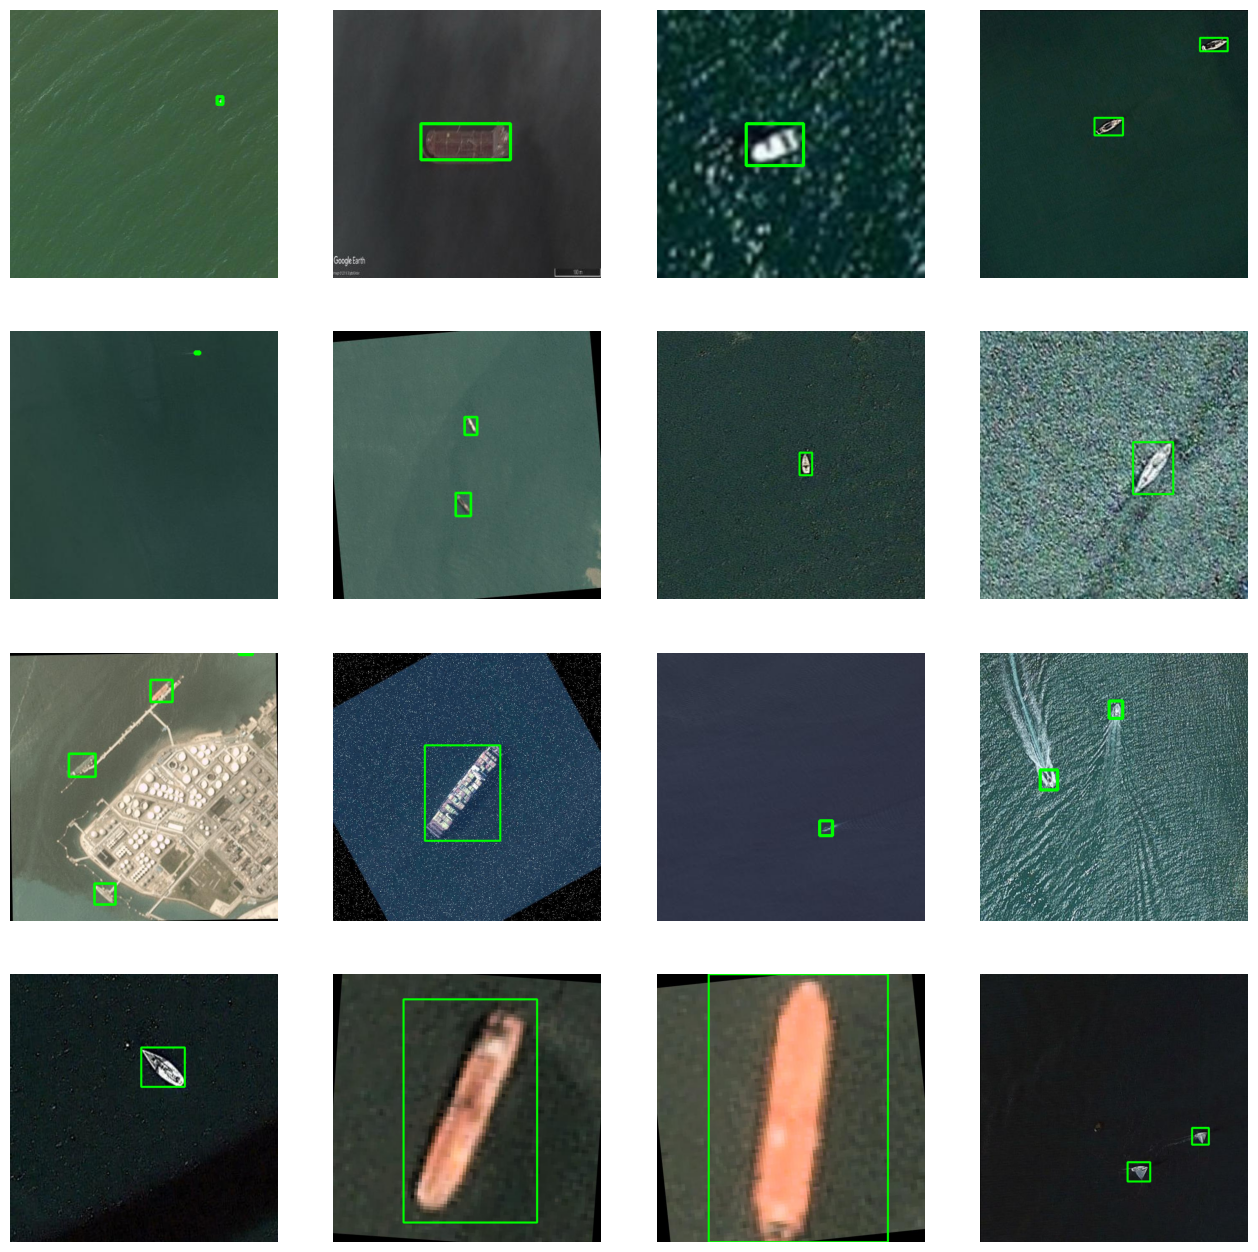

In [16]:
# Define the paths to the images and labels directories
train_images = "/home/mozer/projects/yolo_ship/archive/ships-aerial-images/train/images"
train_labels = "/home/mozer/projects/yolo_ship/archive/ships-aerial-images/train/labels"

test_images = "/home/mozer/projects/yolo_ship/archive/ships-aerial-images/test/images"
test_labels = "/home/mozer/projects/yolo_ship/archive/ships-aerial-images/test/labels"

val_images = "/home/mozer/projects/yolo_ship/archive/ships-aerial-images/valid/images"
val_labels = "/home/mozer/projects/yolo_ship/archive/ships-aerial-images/valid/labels"

# Get a list of all the image files in the training images directory
image_files = os.listdir(train_images)

# Choose 16 random image files from the list
random_images = random.sample(image_files, 16)

# Set up the plot
fig, axs = plt.subplots(4, 4, figsize=(16, 16))

# Loop over the random images and plot the object detections
for i, image_file in enumerate(random_images):
    row = i // 4
    col = i % 4
    
    # Load the image
    image_path = os.path.join(train_images, image_file)
    image = cv2.imread(image_path)

    # Load the labels for this image
    label_file = os.path.splitext(image_file)[0] + ".txt"
    label_path = os.path.join(train_labels, label_file)
    with open(label_path, "r") as f:
        labels = f.read().strip().split("\n")

    # Loop over the labels and plot the object detections
    for label in labels:
        if len(label.split()) != 5:
            continue
        class_id, x_center, y_center, width, height = map(float, label.split())
        x_min = int((x_center - width/2) * image.shape[1])
        y_min = int((y_center - height/2) * image.shape[0])
        x_max = int((x_center + width/2) * image.shape[1])
        y_max = int((y_center + height/2) * image.shape[0])
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 3)

    # Show the image with the object detections
    axs[row, col].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[row, col].axis('off')

plt.show()

In [17]:
model=YOLO("/home/mozer/projects/yolo_ship/yolo11n.pt")

In [18]:
# 1. Import the necessary library
from ultralytics import YOLO

# 2. Define your aggressive hyperparameters for augmentation
# These parameters directly control the geometric and photometric augmentations
aggressive_hypers = {
    # Geometric Augmentation
    'scale': 0.2,       # Aggressive scaling down (allows ships to be 20% of original size)
    'degrees': 15.0,    # Increased rotation (up to +/- 15 degrees)
    'shear': 5.0,       # Increased shear (up to +/- 5 degrees)
    'perspective': 0.0005, # Small perspective change
    
    # Photometric Augmentation (HSV)
    'hsv_h': 0.1,       # Hue adjustment
    'hsv_s': 0.7,       # Aggressive Saturation adjustment (simulates haze/glare)
    'hsv_v': 0.5,       # Aggressive Brightness (Value) adjustment (simulates varied lighting)
    
    # Advanced Augmentation
    'mosaic': 0.8,      # High probability for Mosaic (combines 4 images)
    'mixup': 0.1,       # Probability for MixUp (blends 2 images)
}

In [ ]:
# Configure GPU settings
import torch

# Check GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"Memory Available: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    
    # Enable GPU memory growth
    torch.cuda.empty_cache()
    
    # Set GPU batch size based on available memory
    gpu_batch_size = 16  # You can adjust this based on your GPU memory

# 3. Load the pre-trained model weights and move to GPU
#model = YOLO('/home/mozer/projects/yolo_ship/yolo11n.pt')
model = model.to(device)

# 4. Start the training session with GPU optimization
results = model.train(
    data='/home/mozer/projects/yolo_ship/data.yaml',   # Path to your ship dataset configuration
    epochs=100,                       # Number of epochs to train
    imgsz=640,                        # Image size (e.g., 640)
    batch=gpu_batch_size if torch.cuda.is_available() else 8,  # Use GPU batch size if available
    device=0 if torch.cuda.is_available() else 'cpu',  # Use GPU device 0 if available
    workers=8 if torch.cuda.is_available() else 4,     # More workers for GPU
    amp=True,                         # Automatic Mixed Precision for faster training
    **aggressive_hypers,              # Unpack the aggressive augmentation dictionary
    name='ship_detection_aggressive_aug'
)

# Validation with GPU
print("\nRunning validation...")
metrics = model.val(conf=0.25, split='test', device=0 if torch.cuda.is_available() else 'cpu')

# Get validation metrics
metrics = model.val()  # no arguments needed, dataset and settings remembered
print("\nValidation Metrics:")
print(f"mAP50-95: {metrics.box.map}")
print(f"mAP50: {metrics.box.map50}")
print(f"mAP75: {metrics.box.map75}")
print(f"Maps: {metrics.box.maps}")

GPU Name: NVIDIA GeForce GTX 1660 Ti
Memory Available: 6.03 GB
CUDA Error: CUDA error: unspecified launch failure
Search for `cudaErrorLaunchFailure' in https://docs.nvidia.com/cuda/cuda-runtime-api/group__CUDART__TYPES.html for more information.
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


Trying to recover...


AcceleratorError: CUDA error: unspecified launch failure
Search for `cudaErrorLaunchFailure' in https://docs.nvidia.com/cuda/cuda-runtime-api/group__CUDART__TYPES.html for more information.
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


: 

In [ ]:
# Save the trained model
# Save in both ONNX and PyTorch formats for flexibility
save_dir = "trained_models"
os.makedirs(save_dir, exist_ok=True)

# Save PyTorch model
torch_path = os.path.join(save_dir, "ship_detector_final.pt")
model.save(torch_path)
print(f"Model saved to {torch_path}")

# Export to ONNX format (useful for deployment)
onnx_path = os.path.join(save_dir, "ship_detector_final.onnx")
model.export(format="onnx", imgsz=640)
print(f"Model exported to ONNX format at {onnx_path}")